### CORE - UPDATE DATA CATALOG

~ Step 3 ~ 

Append a row to the Data Catalog for each new training sample. This entry contains meta-data used for processing and filtering prior to model training.

Date: 2019-10-18
Author: Eric Pietraszkiewicz

In [1]:
import numpy as np
import os, sys
import os.path
from os import path
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import shapely
import descarteslabs as dl
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist

import geopandas as gpd
# import earthpy as et2
# import earthpy.spatial as es
import pandas as pd

import gdal

import UTC_util_raster
import UTC_util_shp
import UTC_util_mask
import UTC_util_imagery

# Set working directory 
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

/home/ericp/anaconda3/envs/pcp-env/lib/python3.7/site-packages/osgeo/gdal.py:107: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


In [2]:
# variables you probably should change each time!!!

place = 'Santa_Monica'

imgtype, imgsource = 'NAIP', 'naip1'
# imgtype, imgsource = 'SPOT', 'spot2'
# imgtype, imgsource = 'Pleiades', 'plds2'

suffix='A' 
zfill = 5

lidar_src = 'USGS_LPC_CA_LosAngeles_2016_LAS_2018'
lidar_year = 2016

In [3]:
# variables you probably wont need to change!
data_root='/datadrive/UTC/'
data_path=data_root+place+'/'

tile_resolution = 1 
tile_size = 256
tile_pad = 0
processing_level = None
bands=['red','green','blue','nir'];  # S2, Lx
resolution=tile_resolution  # Lx:15 S2:10

imageryID = place+'_'+imgsource+'_'+suffix+'_'+str(resolution)+'m_p'+str(tile_pad)
lidarID = place+'_lidar_'+str(resolution)+'m_p'+str(tile_pad)

#### LOAD AND INSPECT STUDY AREA

Santa_Monica Santa_Monica
simple polygon
center co-ordinates -118.48058205883515 34.02288192785845


/home/ericp/Notebooks/UTC_util_shp.py:30: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  pol = c.next()


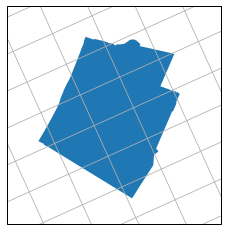

In [4]:
shape, albers, lonlat_crs, place_shp = UTC_util_shp.draw_shp(data_root, place, figdim=4)

#### GENERATE TILES

number of tiles to cover region 391


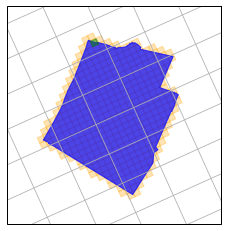

In [5]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 4
highlights = {single_tile_id:'green'}
UTC_util_shp.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights, figdim=4)

#### CREATE OR MODIFY EXISTING DATA CATALOG

In [6]:
catalog_path = data_root+'data_catalog.csv'

if path.exists(catalog_path):
    data_catalog = pd.read_csv(catalog_path) 
    print ('modifying existing catalog')
else:
    data_catalog = pd.DataFrame([],columns = [
                           'raster_path',
                           'imagery_path',
                           'binary_path',
                           'place',
                           'tileID',
                           'suffix',
                           'img_size',
                           'res',
                           'pad',
                           'lat',
                           'long',
                           'img_src',
                           'lidar_src', 
                           'band_means',
                           'band_stds',
                           'ndvi_mean',
                           'ndvi_std',
                           'ndvi_NaN',
                           'height_mean',
                           'height_std',
                           'height_NaN']
                           )
    print ('creating new catalog')

creating new catalog


#### POPULATE DATAFRAME

In [2]:
sample = False # set sample to True if 10% random sample of geography is desired

if sample == False:
    img_list = range(len(tiles['features']))
if sample == True:
    img_list = UTC_util_imagery.gen_randlist(0, tiles, tile_start =0)
#     problemTiles for LA = 
    for x in [17139, 18544, 5905, 14867]:
        img_list.remove(x)

for tile in img_list:
    
    raster_path = data_path+'combiTif/'+imageryID+'_tile'+str(tile).zfill(zfill)+'.tif'
    imagery_path = data_path+imgtype+'/imagery/none/'+imageryID+'_tile'+str(tile).zfill(zfill)+'.tif'
    binary_path = data_path+'fullMasks/binary/'+imageryID+'_bi4_tile'+str(tile).zfill(zfill)+'.tif'
    
    with rio.open(raster_path) as src:
        sourceR = src.read()
        raster = sourceR.astype(float)
    
    with rio.open(imagery_path) as src:
        sourceI = src.read()
        imagery = sourceI.astype(float)
        imagery[imagery==255] = np.nan
    
#     get corner coordinates
    obj = gdal.Open(raster_path, gdal.gdalconst.GA_ReadOnly)
    out_geo = obj.GetGeoTransform()
    minx, miny = out_geo[0], out_geo[3]
    
#     get image size
    img_shape = raster.shape
    if img_shape[1]!=img_shape[2]:
        print ('img not square !?')
    img_size = img_shape[1]
    
#     get raster statistics
    height_band = raster[0]
    height_mean, height_std, height_NaN = UTC_util_raster.get_bandStats(height_band)
#     print (height_NaN)

    ndvi_band = raster[1]
    ndvi_mean, ndvi_std, ndvi_NaN = UTC_util_raster.get_bandStats(ndvi_band)
#     print (ndvi_NaN)

    R_band = imagery[0]
    R_mean, R_std, R_NaN = UTC_util_raster.get_bandStats(R_band)

    G_band = imagery[1]
    G_mean, G_std, G_NaN = UTC_util_raster.get_bandStats(G_band)

    B_band = imagery[2]
    B_mean, B_std, B_NaN = UTC_util_raster.get_bandStats(B_band)

    NIR_band = imagery[3]
    NIR_mean, NIR_std, NIR_NaN = UTC_util_raster.get_bandStats(NIR_band)
    
    imagery_means = [R_mean,G_mean,B_mean,NIR_mean]
    imagery_stds = [R_std,G_std,B_std,NIR_std]
    
    datapoint = {'raster_path':[raster_path],
                           'imagery_path':[imagery_path],
                           'binary_path':[binary_path],
                           'place':[place],
                           'tileID':[tile],
                           'suffix':[suffix],
                           'img_size':[img_size],
                           'res':[resolution],
                           'pad':[tile_pad],
                           'lat':[minx],
                           'long':[miny],
                           'img_src':[imgsource],
                           'lidar_src':[lidar_src], 
                           'band_means':[imagery_means],
                           'band_stds':[imagery_stds],
                           'ndvi_mean':[ndvi_mean],
                           'ndvi_std':[ndvi_std],
                           'ndvi_NaN': [ndvi_NaN],
                           'height_mean':[height_mean],
                           'height_std':[height_std],
                           'height_NaN': [height_NaN]}
    
    new_row = pd.DataFrame(datapoint)
    data_catalog = data_catalog.append(new_row)
    data_catalog = data_catalog.drop_duplicates(subset=['place','tileID','suffix','img_src','pad'])

NameError: name 'tiles' is not defined

In [4]:
# review the new dataframe - check below!
# data_catalog

In [5]:
# all NaN's should be removed from df - check below!
# data_catalog.isnull().sum(axis = 0)

#### WRITE DF TO CSV 

In [11]:
data_catalog.to_csv(catalog_path, index=False)

-----------------------------------------